# Function

In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
import h5py
import glob, os, time
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import logging
from PIL import Image
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model

In [3]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            
            # orderdict to list
            weight = [lay[1] for lay in mod.state_dict().items()]
            # apply
            for i, layer in enumerate(self.frontend.state_dict().items()):
                layer[1].data[:] = weight[i].data[:]
                
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)                

In [4]:
# model = CSRNet()
# model(torch.FloatTensor(5,3,128,128).zero_()).shape

## Dataset

### augments

In [5]:
class RandomResizedCrop:
    def __init__(self, size, scale):
        self.transform = transforms.RandomResizedCrop(size = size, scale= scale)
        
    def __call__(self, img, hot_map):
        crop_indices = self.transform.get_params(img, \
                                                 scale = self.transform.scale, \
                                                 ratio = self.transform.ratio)
        i, j, h, w = crop_indices
        return TF.resized_crop(img, i, j, h, w, self.transform.size, self.transform.interpolation),\
                TF.resized_crop(hot_map, i, j, h, w, self.transform.size, self.transform.interpolation)

class RandomRotation:
    def __init__(self, max_angle = 90):
        self.max_angle = max_angle
        
    def __call__(self, img, hot_map):
        angle = random.random() * self.max_angle
        return TF.rotate(img, angle), TF.rotate(hot_map, angle)
    
class RandomVFlip:
    def __init__(self):
        pass
    def __call__(self, img, hot_map):
        return TF.vflip(img), TF.vflip(hot_map)

class RandomHFlip:
    def __init__(self):
        pass
    def __call__(self, img, hot_map):
        return TF.hflip(img), TF.hflip(hot_map)

class FixTransforms:
    # apply the same augmentations on both input and gt
    def __init__(self, augmentations, probs):
        self.augmentations = augmentations
        self.probs = probs

    def __call__(self, img, hot_map):
        # both img, hot_map are PIL
        for i, augmentation in enumerate(self.augmentations):
            if random.random() < self.probs[i]:
                img, hot_map = augmentation(img, hot_map)
        return img, hot_map

### dataset

In [6]:
class SDD(Dataset):
    def __init__(self, size = 512):
        super(SDD, self).__init__()
        self.file_list = glob.glob('data/raw/*.h5')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

        self.aug = FixTransforms([
            RandomHFlip(),
            RandomVFlip(),
#             RandomRotation(),
            RandomResizedCrop(size = size, scale=(0.7, 1.0)),
        ], probs = [0.5, 0.5, 1, 1])
        

    def __getitem__(self, index):
        data = h5py.File(self.file_list[index], 'r')
        xs, ys = np.asarray(data['img']), np.asarray(data['map'])
        
        xs = TF.to_pil_image(xs)
        ys = TF.to_pil_image(ys)
        
        xs, ys = self.aug(xs, ys)
        
        xs = self.transform(xs)
        ys = TF.resize(ys, [int(ys.size[1]/8), int(ys.size[0]/8)])
        ys = TF.to_tensor(ys)

        return xs, ys

    def __len__(self):
        return len(self.file_list)
    
class ValSDD(Dataset):
    def __init__(self):
        super(ValSDD, self).__init__()
        self.file_list = glob.glob('data/val/*.h5')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, index):
        data = h5py.File(self.file_list[index], 'r')
        xs, ys = np.asarray(data['img']), np.asarray(data['map'])
        
        xs = TF.to_pil_image(xs)
        ys = TF.to_pil_image(ys)
        
        xs = self.transform(xs)
        ys = TF.resize(ys, [int(ys.size[1]/8), int(ys.size[0]/8)])
        ys = TF.to_tensor(ys)
        return xs, ys

    def __len__(self):
        return len(self.file_list)
    
class TestData(Dataset):
    def __init__(self):
        super(TestData, self).__init__()
        self.file_list = glob.glob('data/test/*.png')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, index):
        xs = Image.open(self.file_list[index]).convert('RGB')
        xs = self.transform(xs)
        return xs

    def __len__(self):
        return len(self.file_list)

## eval func

In [7]:
def evalfunc(model, VLoader, criterion, scaling_factor):
    model.eval()
    loss, count = 0, 0
    with torch.no_grad():
        for n_count, (x, y) in enumerate(VLoader):
            output = model(x.to(device))
            loss += criterion(output, y.to(device) * scaling_factor)
            count += 1
    model.train()
    return loss/count
    

# Main

In [ ]:
n_epoch = 40
batch_size = 32
scaling_factor = 1e6


# model dir
save_dir = 'model/trial2/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# logger
logger = logging.getLogger()
hdlr = logging.FileHandler(os.path.join(save_dir, 'train.log'))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.INFO)

# model
model = CSRNet().to(device)
model.train()

# dataset
d = SDD(size = 384)
DLoader = DataLoader(dataset = d, num_workers = 8, batch_size = batch_size, shuffle = True)
v = ValSDD()
VLoader = DataLoader(dataset = v, num_workers = 1, batch_size = 1, shuffle = False)

# criterion
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler
scheduler = MultiStepLR(optimizer, milestones=[5,15,25], gamma=0.5)

init_epoch = 0
# init_epoch = findLastCheckpoint(save_dir=save_dir)  # load the last model in matconvnet style
# if init_epoch > 0:
#     print('resuming by loading epoch %03d' % init_epoch)
#     model.load_state_dict(\
#                 torch.load(os.path.join(save_dir, 'model_%03d.pth' % init_epoch))['stat_dict']\
#                           )
#     optimizer.load_state_dict(\
#                 torch.load(os.path.join(save_dir, 'model_%03d.pth' % init_epoch))['op_stat_dict']
#                           )

for epoch in range(init_epoch, n_epoch):
    scheduler.step(epoch)
    
    start_time = time.time()
    start_time2 = time.time()
    for n_count, (x, y) in enumerate(DLoader):
        
        optimizer.zero_grad()

        output = model(x.to(device))
        loss = criterion(output, y.to(device) * scaling_factor)
        
        loss.backward()
        optimizer.step()

        if n_count % 10 == 0: 
            if n_count % 80 == 0:
                val_loss = evalfunc(model, VLoader, criterion, scaling_factor)
                info = '%4d %4d / %4d loss = %2.4f eval_loss = %2.4f time = %2.4fsec' % \
                      (epoch+1, n_count, DLoader.__len__(), loss.item()/batch_size, \
                       val_loss, time.time()-start_time)
                logger.info(info)
                print(info)
            else:
                info = '%4d %4d / %4d loss = %2.4f time = %2.4fsec' % \
                      (epoch+1, n_count, DLoader.__len__(), loss.item()/batch_size, \
                       time.time()-start_time)
                logger.info(info)
                print(info)
                start_time = time.time()
        

    elapsed_time = time.time() - start_time
    torch.save({'stat_dict': model.state_dict(), \
                'op_stat_dict': optimizer.state_dict()
               }
               , os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))

/home/ko/test/lib/python3.5/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


   1    0 /  179 loss = 58.2801 eval_loss = 2370.2954 time = 26.2066sec
   1   10 /  179 loss = 76.6972 time = 57.3780sec
   1   30 /  179 loss = 38.3890 time = 30.9142sec
   1   40 /  179 loss = 33.2045 time = 53.2966sec
   1   50 /  179 loss = 40.1739 time = 43.3781sec
   1   60 /  179 loss = 61.8056 time = 48.8773sec
   1   70 /  179 loss = 71.4284 time = 38.0056sec
   1   80 /  179 loss = 65.6059 eval_loss = 2322.8669 time = 68.8765sec
   1   90 /  179 loss = 32.6220 time = 102.9918sec
   1  100 /  179 loss = 41.9474 time = 41.1371sec
   1  110 /  179 loss = 73.1842 time = 44.3810sec
   1  120 /  179 loss = 43.8483 time = 55.2650sec
   1  130 /  179 loss = 55.9562 time = 43.2463sec
   1  140 /  179 loss = 49.8691 time = 50.3189sec
   1  150 /  179 loss = 46.2581 time = 42.2194sec
   1  160 /  179 loss = 24.1443 eval_loss = 2330.6428 time = 53.1888sec
   1  170 /  179 loss = 46.9355 time = 90.8824sec
   2    0 /  179 loss = 47.9442 eval_loss = 2382.0625 time = 29.1380sec
   2   10 /

# Evaluation

In [35]:
model = CSRNet().to(device)
model.load_state_dict(torch.load('model/trial2/model_020.pth')['stat_dict'])
# model.load_state_dict(torch.load('model/trial/model_050.pth')['stat_dict'])

<All keys matched successfully>

In [38]:
dd = TestData()
DD = DataLoader(dataset = dd, num_workers = 1, batch_size = 1, shuffle = False)
model.eval()
for n_count, x in enumerate(DD):
    if n_count < 0:
        continue
    output = model(x.to(device))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


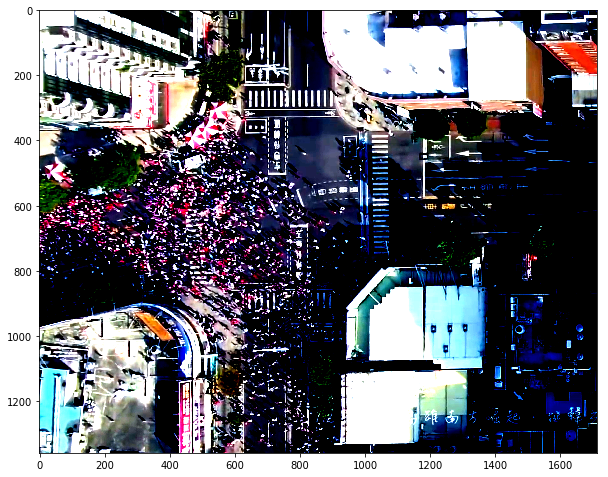

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).cpu().detach().numpy())
plt.clim(0,1)

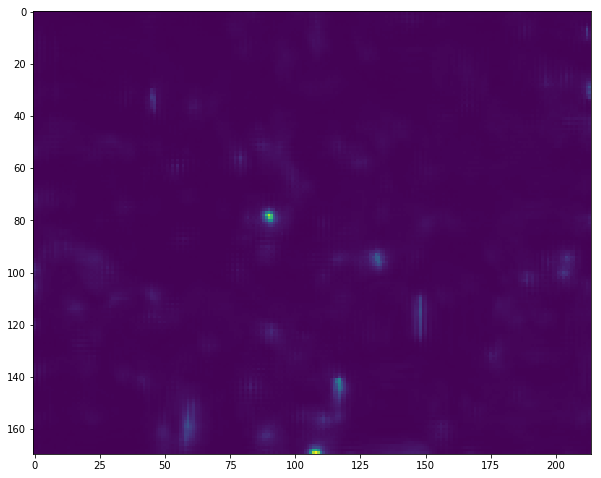

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(output[0,0].cpu().detach().numpy())

In [32]:
for n_count, x in enumerate(DD):
    if n_count < 1:
        continue
    output = model(x.to(device))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


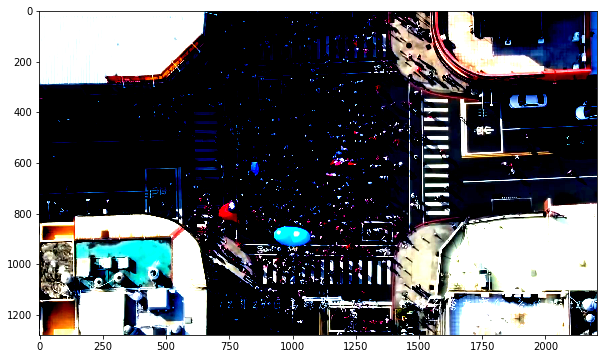

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).cpu().detach().numpy())
plt.clim(0,1)

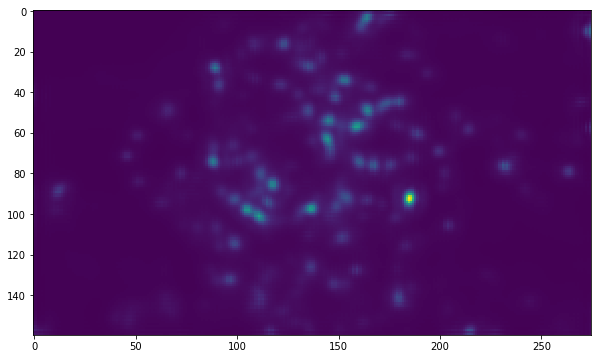

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(output[0,0].cpu().detach().numpy())

# Backup

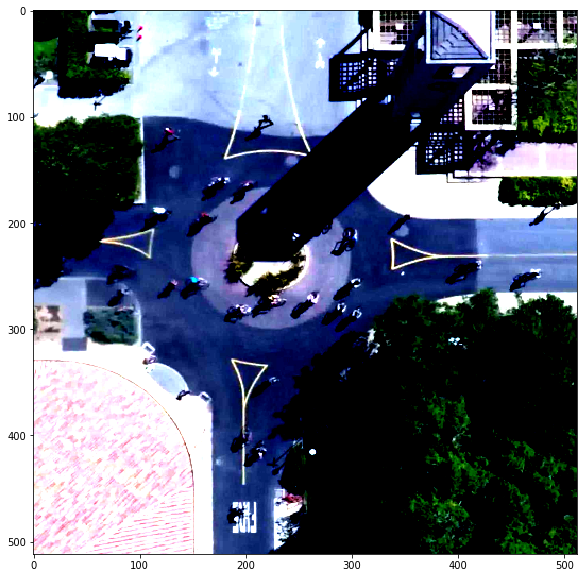

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).numpy())
plt.clim(0,1)


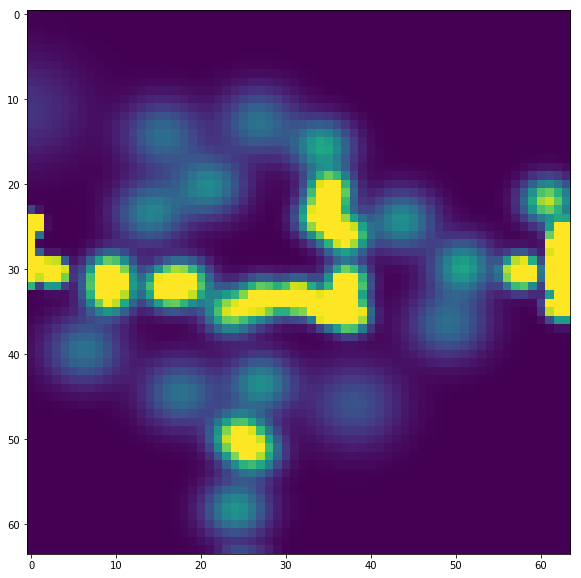

In [99]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(y[0,0,...].numpy()*10000)
plt.clim(0,1)